# Building Custom Dataset

In [3]:
root_dir = "/content/drive/MyDrive/Sign_Language_Detection/dataset"
csv_dir = "/content/drive/MyDrive/Sign_Language_Detection/dataset/dataset.csv"

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage import io

from torch.utils.data import Dataset

class SignLanguageDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.dataset_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.dataset_frame)
  
  def __getitem__(self, index):
    image_name = os.path.join(self.root_dir, self.dataset_frame.iloc[index, 0])
    image = cv2.imread(image_name)
    # Image is already read in RGB format, since image was stored in BGR format

    y_label = self.dataset_frame.iloc[index,1]

    if self.transform:
      image = self.transform(image)
    
    return (image, y_label)

In [5]:
sign_lang_dataset = SignLanguageDataset(csv_file=csv_dir, root_dir=root_dir)
print(f'Length of dataset: {len(sign_lang_dataset)}')

Length of dataset: 1680


In [6]:
classes = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

Image shape: (100, 100, 3)


Text(0.5, 1.0, 'A')

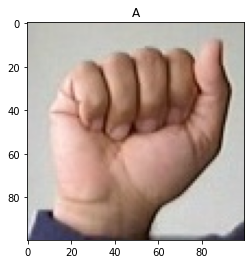

In [11]:
import matplotlib.pyplot as plt

# Display a couple of images from dataset
idx = 1441
image, label = sign_lang_dataset[idx]
print(f'Image shape: {image.shape}')


plt.imshow(image, cmap='gray')
plt.title(classes[label])

In [7]:
import cv2
import torch
from torchvision import transforms, utils

class Normalize(object):
  """Convert the color image to grayscale image and normalize the color range to [0,1]"""
  def __call__(self, sample):
    image = sample

    image_copy = np.copy(image)

    # convert image to grayscale
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # scale range [0,1]
    image_copy = image_copy / 255.0

    return image_copy
  
class Rescale(object):
  """Rescale the image to a given size"""
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image = sample
    h,w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h>w:
        new_h, new_w = self.ouptut_size * h/w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size * w/h
    else:
      new_h, new_w = self.output_size
    
    new_h, new_w = int(new_h), int(new_w)
    img = cv2.resize(image, (new_w, new_h))
    return img

class RandomCrop(object):
  """Crop randomly the image in a sample"""
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      self.output_size = output_size
    
  def __call__(self, sample):
    image = sample
    h,w = image.shape[:2]
    new_h, new_w = self.output_size
    top = np.random.randint(0, h-new_h)
    left = np.random.randint(0, w-new_w)
    image = image[top:top+new_h, left:left+new_w]
    
    return image

class ToTensor(object):
  def __call__(self, sample):
    image = sample

    # if image has only two dimensions, add one
    if len(image.shape) == 2:
      image = image.reshape(image.shape[0], image.shape[1], 1)

    # swap color axis
    image = image.transpose((2,0,1))
    return torch.from_numpy(image)

In [8]:
# Creating transformed dataset
transform = transforms.Compose([Rescale(250),
                                RandomCrop(224),
                                Normalize(),
                                ToTensor()])

transformed_dataset = SignLanguageDataset(csv_dir, root_dir, transform=transform)
print(f'Length of transfromed dataset: {len(transformed_dataset)}')

Length of transfromed dataset: 1680


torch.float64


Text(0.5, 1.0, 'W')

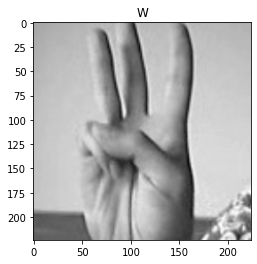

In [12]:
idx = 450
sample = transformed_dataset[idx]
image, label = sample
print(image.dtype)
plt.imshow(np.squeeze(image), cmap='gray')
plt.title(classes[label])

# Building CNN Architecture

In [13]:
# Hyperparameters
batch_size = 40
lr = 0.001
epochs = 5

In [14]:
# Load data

# import libraries
from torch.utils.data import DataLoader

transform = transforms.Compose([Rescale(256),
                                RandomCrop(224),
                                Normalize(),
                                transforms.ToTensor()])

dataset = SignLanguageDataset(csv_dir, root_dir, transform=transform)
print(len(dataset))

train_set, test_set = torch.utils.data.random_split(dataset, [1200, 480])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=8)

1680


In [15]:
print(len(train_loader))
print(len(test_loader))

30
12


In [16]:
# Build CNN Architecture

# Importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self, in_channels=1, num_classes=24):
    super(Net,self).__init__()

    # conv layers
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))

    # pool layers
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # dense layers
    self.fc1 = nn.Linear(in_features=32*56*56, out_features=num_classes)

    # dropout regularization
    self.dropout = nn.Dropout(p=0.5)

    # activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    return x

In [17]:
# Device config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
# Test CNN model

X = torch.randn(batch_size, 1, 224, 224, device=device)
net = Net().to(device)
output = net(X)
print(output.shape)

torch.Size([40, 24])


In [19]:
# Test the model before training
def test():
  # Eval mode
  net.eval()

  num_correct = 0
  num_samples = 0

  with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
      images, labels = data

      # move images, and labels to cuda if available
      images = images.to(device)
      labels = labels.to(device)

      # forward pass
      output = net(images.float())

      preds = F.softmax(output.float(), dim=1)
      _, preds = torch.max(preds, dim=1)

      num_correct += (preds == labels).sum()
      num_samples += preds.size(0)

  acc = 100.0 * num_correct / num_samples
  print(f'Test dataset accuracy: {acc:.2f}%')

test()

Test dataset accuracy: 2.29%


In [20]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=lr)

In [21]:
# Train the data
def train():
  # train mode
  net.train()
  training_loss = []
  for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
      images, labels = data

      # move images, and labels to cuda if available
      images = images.to(device)
      labels = labels.to(device)

      # forward pass
      output = net(images.float())

      # calculate loss
      loss = criterion(output, labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f'Epoch: {epoch+1}/{epochs}\t Training Loss: {running_loss / len(train_loader) :.6f}')
    training_loss.append(running_loss)
  print('Finished training')

In [22]:
train()

Epoch: 1/5	 Training Loss: 3.622577
Epoch: 2/5	 Training Loss: 1.880478
Epoch: 3/5	 Training Loss: 1.478687
Epoch: 4/5	 Training Loss: 1.225330
Epoch: 5/5	 Training Loss: 1.071393
Finished training


In [23]:
test()

Test dataset accuracy: 61.46%


In [24]:
# Let's train for more number of epochs
epochs = 20
train()

Epoch: 1/20	 Training Loss: 0.951113
Epoch: 2/20	 Training Loss: 0.962661
Epoch: 3/20	 Training Loss: 0.841672
Epoch: 4/20	 Training Loss: 0.779452
Epoch: 5/20	 Training Loss: 0.682780
Epoch: 6/20	 Training Loss: 0.625437
Epoch: 7/20	 Training Loss: 0.585972
Epoch: 8/20	 Training Loss: 0.593630
Epoch: 9/20	 Training Loss: 0.503510
Epoch: 10/20	 Training Loss: 0.473882
Epoch: 11/20	 Training Loss: 0.453605
Epoch: 12/20	 Training Loss: 0.412589
Epoch: 13/20	 Training Loss: 0.422786
Epoch: 14/20	 Training Loss: 0.360489
Epoch: 15/20	 Training Loss: 0.364100
Epoch: 16/20	 Training Loss: 0.352690
Epoch: 17/20	 Training Loss: 0.374647
Epoch: 18/20	 Training Loss: 0.319953
Epoch: 19/20	 Training Loss: 0.318980
Epoch: 20/20	 Training Loss: 0.273432
Finished training


In [25]:
test()

Test dataset accuracy: 77.50%


In [26]:
# Hyperparamter tuning
epochs = 50
train()
test()

Epoch: 1/50	 Training Loss: 0.319357
Epoch: 2/50	 Training Loss: 0.263620
Epoch: 3/50	 Training Loss: 0.296918
Epoch: 4/50	 Training Loss: 0.259289
Epoch: 5/50	 Training Loss: 0.258149
Epoch: 6/50	 Training Loss: 0.195403
Epoch: 7/50	 Training Loss: 0.197075
Epoch: 8/50	 Training Loss: 0.246294
Epoch: 9/50	 Training Loss: 0.205936
Epoch: 10/50	 Training Loss: 0.220875
Epoch: 11/50	 Training Loss: 0.156280
Epoch: 12/50	 Training Loss: 0.191707
Epoch: 13/50	 Training Loss: 0.254420
Epoch: 14/50	 Training Loss: 0.209310
Epoch: 15/50	 Training Loss: 0.221083
Epoch: 16/50	 Training Loss: 0.195728
Epoch: 17/50	 Training Loss: 0.232965
Epoch: 18/50	 Training Loss: 0.209598
Epoch: 19/50	 Training Loss: 0.143640
Epoch: 20/50	 Training Loss: 0.161324
Epoch: 21/50	 Training Loss: 0.142833
Epoch: 22/50	 Training Loss: 0.131528
Epoch: 23/50	 Training Loss: 0.121188
Epoch: 24/50	 Training Loss: 0.162824
Epoch: 25/50	 Training Loss: 0.132320
Epoch: 26/50	 Training Loss: 0.127623
Epoch: 27/50	 Trainin

In [47]:
# Visualizing test dataset output
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([40, 1, 224, 224])
torch.Size([40])


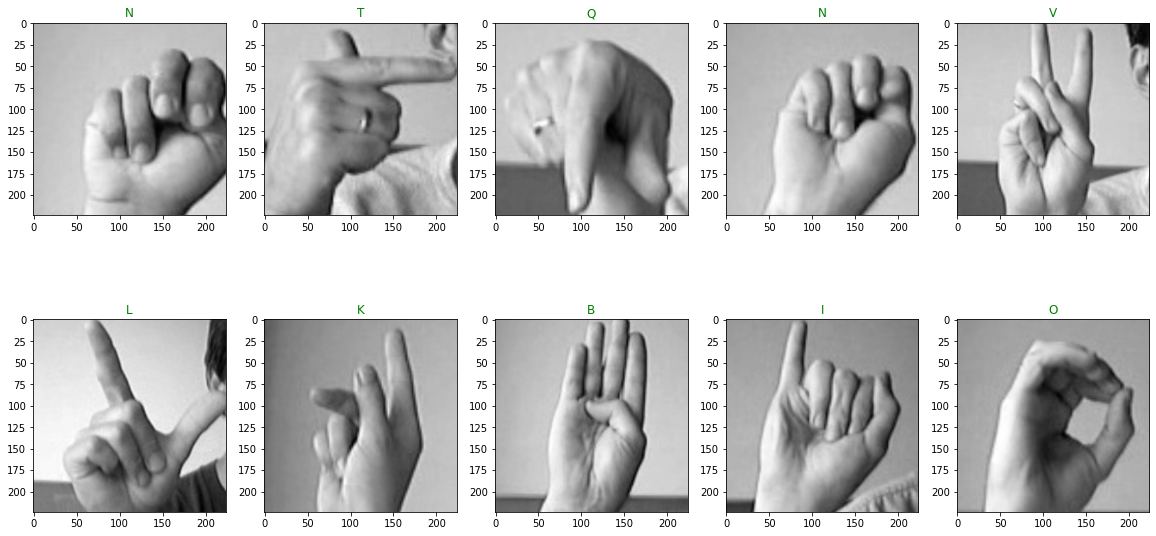

In [48]:
plt.figure(figsize=(20,10))
for i in range(10):
  image = images[i]
  label = labels[i]
  image = image.unsqueeze(0).to(device)
  output = net(image.float())
  pred = F.softmax(output.float(), dim=1)
  _, pred = torch.max(pred, dim=1)

  plt.subplot(2,5,i+1)
  plt.imshow(np.squeeze(image).cpu().numpy(), cmap='gray')
  plt.title(classes[pred], color='g' if (pred == label) else 'r')

plt.show()

In [49]:
# Further hyperparameter tuning can be done to increase the test dataset accuracy!!